In [6]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook    

from IS18 import vistools    
from IS18 import utils          
from IS18 import rectification  
from IS18 import stereo                 
from IS18 import triangulation

import srtm4
import s2p
import rpcm
import pickle
from PIL import Image

from bundle_adjust import ba_timeseries
from bundle_adjust import ba_utils  
from bundle_adjust import data_loader

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
# list the tiff images available in the remote folder
IARPAurl = 'http://138.231.80.166:2332/iarpa-2016/cloud_optimized_geotif/'
myimages = utils.listFD(IARPAurl, 'TIF')

### Load IARPA data

In [159]:
exp_name = "IARPA_RPC_FIT"
input_dir = os.path.join('exp/',exp_name)

# list the tiff images available in the remote folder
IARPAurl = 'http://138.231.80.166:2332/iarpa-2016/cloud_optimized_geotif/'
myimages = utils.listFD(IARPAurl, 'TIF')

# sort the images by acquisition date
myimages = sorted(myimages, key=utils.acquisition_date)
myimages.pop(11)
myimages.pop(13)
myimages.pop(19)
print('Found {} images'.format(len(myimages)))

# set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
aoi = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                        [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field

# select the number of cameras for the current run
n_cam = len(myimages)
print('Number of images to be used:', n_cam)

# load RPC coefficients
myrpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# load image crops
mycrops = data_loader.load_image_crops(myimages, myrpcs, aoi, True, False, True)

print('All data loaded successfully')

Found 47 images
Number of images to be used: 47
Finished loading RPC coefficients
Loading geotiff crops... 47/47
All data loaded successfully


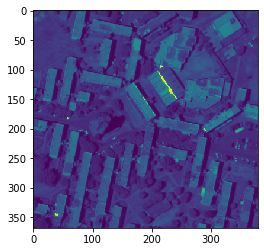

In [160]:
plt.imshow(mycrops[0]['crop'])

In [158]:
from IS18.utils import acquisition_date
iarpa_dates = [acquisition_date(fn) for fn in myimages]

print(sorted(iarpa_dates))

print(len(iarpa_dates))

[datetime.datetime(2014, 11, 15, 13, 51, 21), datetime.datetime(2015, 1, 5, 13, 57, 27), datetime.datetime(2015, 1, 11, 13, 54, 14), datetime.datetime(2015, 1, 23, 13, 46, 52), datetime.datetime(2015, 2, 6, 14, 10, 35), datetime.datetime(2015, 2, 11, 13, 51, 23), datetime.datetime(2015, 2, 12, 14, 6, 52), datetime.datetime(2015, 3, 8, 13, 49, 53), datetime.datetime(2015, 3, 15, 14, 1, 33), datetime.datetime(2015, 3, 21, 13, 57, 4), datetime.datetime(2015, 3, 22, 14, 12, 8), datetime.datetime(2015, 4, 2, 13, 47, 18), datetime.datetime(2015, 4, 2, 13, 48, 4), datetime.datetime(2015, 4, 3, 14, 2, 38), datetime.datetime(2015, 4, 22, 14, 3, 47), datetime.datetime(2015, 5, 4, 13, 53, 49), datetime.datetime(2015, 5, 5, 14, 8, 10), datetime.datetime(2015, 6, 12, 14, 7, 37), datetime.datetime(2015, 6, 18, 14, 2, 7), datetime.datetime(2015, 6, 19, 14, 17, 53), datetime.datetime(2015, 6, 24, 13, 57, 30), datetime.datetime(2015, 6, 30, 13, 53, 23), datetime.datetime(2015, 7, 14, 14, 15, 9), dateti

In [148]:
os.makedirs(input_dir + '/RPC_init', exist_ok=True)
for i, r in zip(myimages, myrpcs):
    r.write_to_file('{}/RPC_init/{}_RPC.txt'.format(input_dir, data_loader.get_id(i)))
print('done')

done


### Run BA

In [144]:
ba_input_data = {}
ba_input_data['input_dir'] = input_dir
ba_input_data['output_dir'] = input_dir
ba_input_data['n_adj'] = 0
ba_input_data['n_new'] = len(myimages)
ba_input_data['image_fnames'] = myimages
ba_input_data['crops'] = mycrops
ba_input_data['rpcs'] = myrpcs
ba_input_data['cam_model'] = 'rpc'
ba_input_data['masks'] = None
ba_input_data['aoi'] = aoi
ba_input_data['correction_params'] = ['R', 'T']

print('ba_input_data set!')

from bundle_adjust.ba_pipeline import BundleAdjustmentPipeline
from bundle_adjust import geojson_utils

tracks_config = {'FT_reset': True, 'FT_sift_detection': 'opencv', 'FT_sift_matching': 'bruteforce'}

# run bundle adjustmenst
ba_pipeline = BundleAdjustmentPipeline(ba_input_data, tracks_config=tracks_config,
                                       fix_ref_cam=True, verbose=True)
geojson_utils.display_lonlat_geojson_list_over_map([aoi], zoom_factor=18)
ba_pipeline.run()

ba_input_data set!
Bundle Adjustment Pipeline created
-------------------------------------------------------------
Configuration:
    - input_dir:    exp/IARPA_RPC_FIT
    - output_dir:   exp/IARPA_RPC_FIT
    - n_new:        47
    - n_adj:        0
    - cam_model:    rpc
    - fix_ref_cam:  True
-------------------------------------------------------------

Estimating camera positions...
Perspective projection matrix approximation... 47/47
...done in 5.87 seconds
Getting image footprints...
...done in 1.14 seconds




Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Building feature tracks - satellite scenario

Parameters:
    - FT_preprocess:        True
    - FT_preprocess_aoi:    False
    - FT_sift_detection:    opencv
    - FT_sift_matching:     bruteforce
    - FT_rel_thr:           0.6
    - FT_abs_thr:           250
    - FT_ransac:            0.3
    - FT_kp_max:            60000
    - FT_kp_aoi:            False
    - FT_K:                 0
    - FT_priority:          ['length', 'scale', 'cost']
    - FT_predefined_pairs:  []
    - FT_filter_pairs:      True
    - FT_n_proc:            1
    - FT_compress:          False
    - FT_reset:             True



Running feature detection...

2181 keypoints in image 0
3544 keypoints in image 1
3624 keypoints in image 2
4174 keypoints in image 3
1294 keypoints in image 4
4112 keypoints in image 5
1509 keypoints in image 6
3852 keypoints in image 7
2421 keypoints in image 8
3537 keypoints in image 9
2290 keypoints in image 10
3358 keypoints in image 11
3542 keypoints in image 12
4185 keypoints i

  47 matches (test ratio:   85, ransac:   47, utm:   47) in pair (2, 30)
   0 matches (test ratio:    3, ransac:    0, utm:    0) in pair (14, 38)
  37 matches (test ratio:   69, ransac:   38, utm:   37) in pair (4, 24)
   7 matches (test ratio:   12, ransac:    7, utm:    7) in pair (26, 45)
   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (0, 40)
   6 matches (test ratio:    7, ransac:    7, utm:    6) in pair (20, 27)
  11 matches (test ratio:   19, ransac:   12, utm:   11) in pair (3, 37)
   0 matches (test ratio:    4, ransac:    0, utm:    0) in pair (6, 18)
  31 matches (test ratio:   66, ransac:   31, utm:   31) in pair (28, 43)
  40 matches (test ratio:   76, ransac:   40, utm:   40) in pair (32, 46)
  29 matches (test ratio:   50, ransac:   29, utm:   29) in pair (31, 46)
  36 matches (test ratio:   79, ransac:   36, utm:   36) in pair (5, 39)
   0 matches (test ratio:    0, ransac:    0, utm:    0) in pair (35, 43)
   0 matches (test ratio:    1, ransac:    0

  19 matches (test ratio:   25, ransac:   19, utm:   19) in pair (7, 18)
   7 matches (test ratio:    9, ransac:    7, utm:    7) in pair (29, 33)
  12 matches (test ratio:   18, ransac:   12, utm:   12) in pair (33, 38)
   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (16, 26)
   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (6, 45)
  27 matches (test ratio:   37, ransac:   27, utm:   27) in pair (10, 32)
  31 matches (test ratio:   72, ransac:   32, utm:   31) in pair (9, 13)
   0 matches (test ratio:    1, ransac:    0, utm:    0) in pair (18, 32)
 918 matches (test ratio: 1317, ransac:  918, utm:  918) in pair (38, 39)
   0 matches (test ratio:    5, ransac:    0, utm:    0) in pair (12, 46)
  30 matches (test ratio:   59, ransac:   30, utm:   30) in pair (8, 22)
   7 matches (test ratio:    8, ransac:    8, utm:    7) in pair (24, 25)
   0 matches (test ratio:    5, ransac:    0, utm:    0) in pair (10, 20)
  30 matches (test ratio:   74, ransac:   

  25 matches (test ratio:   49, ransac:   25, utm:   25) in pair (15, 16)
   0 matches (test ratio:    3, ransac:    0, utm:    0) in pair (11, 16)
  54 matches (test ratio:   86, ransac:   54, utm:   54) in pair (1, 26)
  10 matches (test ratio:   17, ransac:   11, utm:   10) in pair (13, 26)
   0 matches (test ratio:    1, ransac:    0, utm:    0) in pair (3, 28)
   0 matches (test ratio:    4, ransac:    0, utm:    0) in pair (15, 36)
   0 matches (test ratio:    2, ransac:    0, utm:    0) in pair (19, 33)
  58 matches (test ratio:  105, ransac:   58, utm:   58) in pair (5, 30)
   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (27, 33)
   6 matches (test ratio:    9, ransac:    7, utm:    6) in pair (21, 27)
   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (4, 37)
  24 matches (test ratio:   47, ransac:   24, utm:   24) in pair (30, 46)
   7 matches (test ratio:    8, ransac:    7, utm:    7) in pair (8, 32)
   0 matches (test ratio:    4, ransac:    

   0 matches (test ratio:    5, ransac:    0, utm:    0) in pair (3, 45)
  31 matches (test ratio:   83, ransac:   32, utm:   31) in pair (6, 10)
   0 matches (test ratio:    1, ransac:    0, utm:    0) in pair (28, 35)
   7 matches (test ratio:    8, ransac:    7, utm:    7) in pair (2, 42)
  14 matches (test ratio:   22, ransac:   14, utm:   14) in pair (32, 38)
   9 matches (test ratio:   11, ransac:    9, utm:    9) in pair (22, 41)
  24 matches (test ratio:   32, ransac:   24, utm:   24) in pair (9, 36)
 110 matches (test ratio:  191, ransac:  110, utm:  110) in pair (34, 36)
   6 matches (test ratio:    9, ransac:    7, utm:    6) in pair (8, 15)
   0 matches (test ratio:    2, ransac:    0, utm:    0) in pair (7, 41)
   0 matches (test ratio:    4, ransac:    0, utm:    0) in pair (17, 36)
   8 matches (test ratio:   11, ransac:    8, utm:    8) in pair (37, 41)
   7 matches (test ratio:    7, ransac:    7, utm:    7) in pair (11, 42)
  12 matches (test ratio:   23, ransac:   12

  27 matches (test ratio:   49, ransac:   27, utm:   27) in pair (16, 18)
   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (6, 37)
   0 matches (test ratio:    2, ransac:    0, utm:    0) in pair (23, 39)
  34 matches (test ratio:   65, ransac:   34, utm:   34) in pair (10, 40)
   0 matches (test ratio:    3, ransac:    0, utm:    0) in pair (41, 46)
 219 matches (test ratio:  362, ransac:  219, utm:  219) in pair (22, 24)
  20 matches (test ratio:   52, ransac:   20, utm:   20) in pair (31, 39)
   8 matches (test ratio:   17, ransac:    8, utm:    8) in pair (18, 24)
   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (12, 38)
  43 matches (test ratio:   74, ransac:   43, utm:   43) in pair (8, 30)
   0 matches (test ratio:    5, ransac:    0, utm:    0) in pair (14, 20)
  96 matches (test ratio:  161, ransac:   96, utm:   96) in pair (10, 28)
 152 matches (test ratio:  327, ransac:  152, utm:  152) in pair (26, 27)
   7 matches (test ratio:    8, ransac: 

   8 matches (test ratio:   14, ransac:    8, utm:    8) in pair (0, 9)
   0 matches (test ratio:    2, ransac:    0, utm:    0) in pair (3, 4)
   0 matches (test ratio:    5, ransac:    0, utm:    0) in pair (15, 44)
   0 matches (test ratio:    3, ransac:    0, utm:    0) in pair (19, 41)
   7 matches (test ratio:    9, ransac:    8, utm:    7) in pair (5, 6)
 108 matches (test ratio:  206, ransac:  108, utm:  108) in pair (1, 46)
   0 matches (test ratio:    2, ransac:    0, utm:    0) in pair (21, 35)
   7 matches (test ratio:    7, ransac:    7, utm:    7) in pair (4, 45)
  32 matches (test ratio:   51, ransac:   32, utm:   32) in pair (8, 40)
   7 matches (test ratio:   11, ransac:    7, utm:    7) in pair (7, 16)
   6 matches (test ratio:   13, ransac:    7, utm:    6) in pair (29, 35)
   6 matches (test ratio:   12, ransac:    7, utm:    6) in pair (16, 24)
   0 matches (test ratio:    2, ransac:    0, utm:    0) in pair (23, 45)
   0 matches (test ratio:    0, ransac:    0, ut

   0 matches (test ratio:    5, ransac:    0, utm:    0) in pair (9, 44)
  11 matches (test ratio:   17, ransac:   12, utm:   11) in pair (40, 46)
   7 matches (test ratio:    8, ransac:    7, utm:    7) in pair (30, 33)
  38 matches (test ratio:   86, ransac:   38, utm:   38) in pair (17, 28)
   7 matches (test ratio:    8, ransac:    7, utm:    7) in pair (7, 33)
   7 matches (test ratio:    7, ransac:    7, utm:    7) in pair (11, 34)
 107 matches (test ratio:  209, ransac:  107, utm:  107) in pair (42, 44)
   0 matches (test ratio:    2, ransac:    0, utm:    0) in pair (13, 40)
  11 matches (test ratio:   20, ransac:   11, utm:   11) in pair (9, 24)
  15 matches (test ratio:   22, ransac:   16, utm:   15) in pair (25, 29)
   0 matches (test ratio:    0, ransac:    0, utm:    0) in pair (15, 22)
   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (11, 30)
  19 matches (test ratio:   45, ransac:   20, utm:   19) in pair (1, 4)
   7 matches (test ratio:    7, ransac:    

   0 matches (test ratio:    6, ransac:    0, utm:    0) in pair (12, 18)
  13 matches (test ratio:   19, ransac:   13, utm:   13) in pair (2, 24)
   7 matches (test ratio:   13, ransac:    8, utm:    7) in pair (14, 40)
 132 matches (test ratio:  289, ransac:  133, utm:  132) in pair (4, 6)
  34 matches (test ratio:   80, ransac:   34, utm:   34) in pair (0, 46)
   0 matches (test ratio:    3, ransac:    0, utm:    0) in pair (20, 33)
   0 matches (test ratio:    3, ransac:    0, utm:    0) in pair (3, 43)
   8 matches (test ratio:    9, ransac:    8, utm:    8) in pair (6, 20)
   0 matches (test ratio:    3, ransac:    0, utm:    0) in pair (28, 33)
   7 matches (test ratio:    7, ransac:    7, utm:    7) in pair (2, 44)
  12 matches (test ratio:   15, ransac:   14, utm:   12) in pair (32, 36)
  16 matches (test ratio:   35, ransac:   17, utm:   16) in pair (22, 43)
  11 matches (test ratio:   15, ransac:   11, utm:   11) in pair (5, 33)
  19 matches (test ratio:   36, ransac:   19, 

   7 matches (test ratio:   13, ransac:    8, utm:    7) in pair (7, 8)
   0 matches (test ratio:    4, ransac:    0, utm:    0) in pair (23, 37)
   7 matches (test ratio:    9, ransac:    8, utm:    7) in pair (6, 39)
   7 matches (test ratio:    7, ransac:    7, utm:    7) in pair (10, 42)
  33 matches (test ratio:   77, ransac:   33, utm:   33) in pair (22, 26)
  68 matches (test ratio:  142, ransac:   68, utm:   68) in pair (31, 37)
   7 matches (test ratio:   13, ransac:    7, utm:    7) in pair (18, 26)
   0 matches (test ratio:    5, ransac:    0, utm:    0) in pair (12, 36)
   0 matches (test ratio:    2, ransac:    0, utm:    0) in pair (43, 46)
  30 matches (test ratio:   68, ransac:   31, utm:   30) in pair (8, 28)
   0 matches (test ratio:    4, ransac:    0, utm:    0) in pair (24, 31)
  30 matches (test ratio:   54, ransac:   30, utm:   30) in pair (14, 22)
   9 matches (test ratio:   16, ransac:   10, utm:    9) in pair (10, 30)
  11 matches (test ratio:   19, ransac:   

6708 3d points, 0 fixed and 6708 to be optimized
47 cameras, 1 fixed and 46 to be optimized
6 parameters to optimize per camera


Running bundle adjustment...
    - loss:      soft_l1
    - ftol:      0.0001
    - xtol:      1e-10
    - f_scale:   0.5
    - max_iter:  50
    - verbose:   1


Shape of Jacobian sparsity: 41866x20406
The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 8.7328e+04, final cost 6.5920e+04, first-order optimality 4.72e+08.
Optimization took 34.56 seconds

Reprojection error before BA (mean / median): 7.01 / 2.10
Reprojection error after  BA (mean / median): 5.49 / 1.11

    - cam   0 -   565 obs - (mean before / mean after): 10.28 / 8.26
    - cam   1 -   191 obs - (mean before / mean after): 4.81 / 4.60
    - cam   2 -   513 obs - (mean before / mean after): 6.37 / 6.24
    - cam   3 -   506 obs - (mean before / mean after): 6.83 / 5.89
    - cam   4 -   236 obs - (mean before / mean after): 5.04 / 4.62
    - cam   5 

    - cam  44 -   421 obs - (mean before / mean after): 2.33 / 0.30
    - cam  45 -   404 obs - (mean before / mean after): 2.96 / 0.24
    - cam  46 -   338 obs - (mean before / mean after): 5.74 / 0.27


Optimization problem solved in 00:01:04.46 (63 iterations)

cam  1 - RPC fit error per obs [1e-4 px] (max / avg): 0.54 / 0.15
cam  2 - RPC fit error per obs [1e-4 px] (max / avg): 0.96 / 0.26
cam  3 - RPC fit error per obs [1e-4 px] (max / avg): 0.90 / 0.27
cam  4 - RPC fit error per obs [1e-4 px] (max / avg): 1.02 / 0.24
cam  5 - RPC fit error per obs [1e-4 px] (max / avg): 0.92 / 0.25
cam  6 - RPC fit error per obs [1e-4 px] (max / avg): 0.94 / 0.24
cam  7 - RPC fit error per obs [1e-4 px] (max / avg): 0.81 / 0.24
cam  8 - RPC fit error per obs [1e-4 px] (max / avg): 1.21 / 0.26
cam  9 - RPC fit error per obs [1e-4 px] (max / avg): 0.87 / 0.26
cam 10 - RPC fit error per obs [1e-4 px] (max / avg): 0.99 / 0.30
cam 11 - RPC fit error per obs [1e-4 px] (max / avg): 0.93 / 0.23
cam 12 -

Displaying feature track with index 4155, length 2

3D location (before BA):  [ 2743082.2 -4491236.  -3591419.8]
3D location (after BA):   [ 2743079.42348785 -4491232.56265585 -3591417.94664144] 

 --> Real 2D loc in im 36 (yellow):         [496.6541748  193.07594299]
 --> Proj 2D loc in im 36 before BA (red):  [494.91016 192.64844] (reprojection err: 1.796)
 --> Proj 2D loc in im 36 after BA (green): [496.64325008 193.07136924] (reprojection err: 0.012)


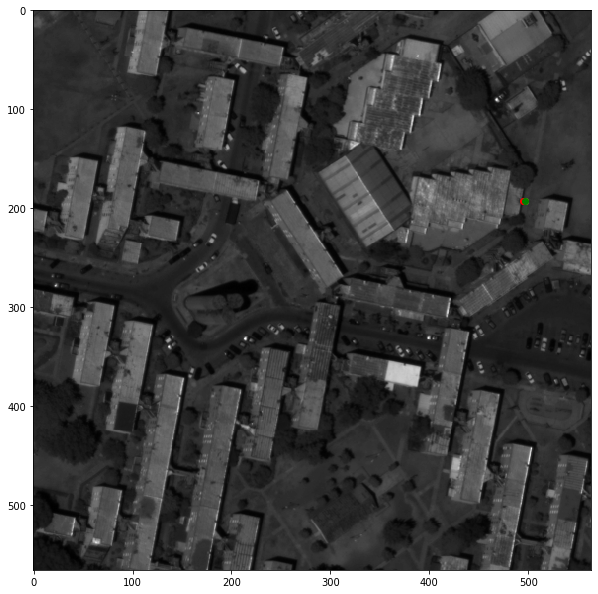

 --> Real 2D loc in im 37 (yellow):         [502.17572021 192.26168823]
 --> Proj 2D loc in im 37 before BA (red):  [500.02734 192.25781] (reprojection err: 2.148)
 --> Proj 2D loc in im 37 after BA (green): [502.18652494 192.26567112] (reprojection err: 0.012)


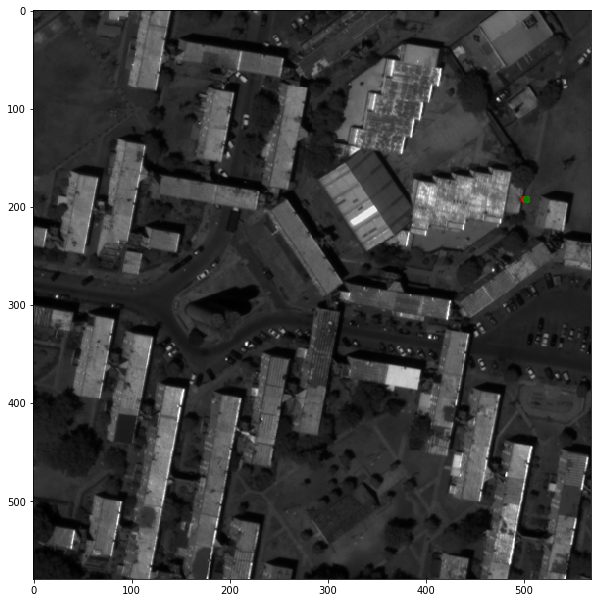

Mean reprojection error before BA: 1.972
Mean reprojection error after BA:  0.012


In [138]:
ba_pipeline.visualize_feature_track()

path to image: None
Reprojection error before BA (mean / median): 4.18 / 3.23
Reprojection error after  BA (mean / median): 0.36 / 0.16



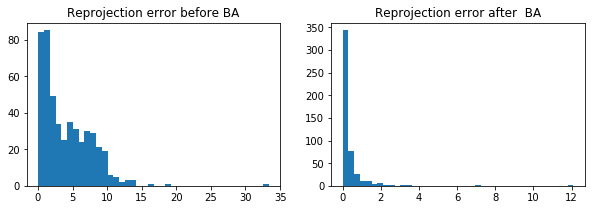

In [139]:
ba_pipeline.analyse_reprojection_error_per_image(2)